# Part 1. Scraping Table from Wikipedia page

**import modules needed**

In [1]:
import pandas as pd

**Read URL as html**

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html = pd.read_html(url)

**Convert the html tables list into pandas dataframe**

In [3]:
df = pd.DataFrame(html[0])
df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront


**Drop the rows where `Borough` is `Not assigned`**

In [4]:
df = df.drop(df[df['Borough']=='Not assigned'].index.values).reset_index(drop=True)
df.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Regent Park / Harbourfront
3,M6A,North York,Lawrence Manor / Lawrence Heights
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government


**Change the Neighborhood name to Borough name if Neighborhood's name is `Not assigned`**

In [5]:
df['Neighborhood'].replace('Not assigned', df.loc[df[df['Neighborhood']=='Not assigned'].index.values,'Borough'], inplace=True)
df.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Regent Park / Harbourfront
3,M6A,North York,Lawrence Manor / Lawrence Heights
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government


**Print the number of rows and columns of the dataframe**

In [6]:
print('There are {} rows & {} columns in the dataframe.'.format(df.shape[0], df.shape[1]))

There are 103 rows & 3 columns in the dataframe.


-----
# Part 2. Adding Coordinates into the dataframe

**Since geocoder is not working anymore, due to google map Api new requirements, use the coordinates csv file instead**

In [7]:
df_coords = pd.read_csv('Geospatial_Coordinates.csv')
df_coords.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


**Merge the two dataframes by joining them on `Postal code`**

In [8]:
df = df.join(df_coords.set_index('Postal Code'), on='Postal Code')
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636
3,M6A,North York,Lawrence Manor / Lawrence Heights,43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.662301,-79.389494


-----
# Part 3.

**Import libraries that will be used in this section**

In [9]:
import requests
import pandas as pd
import numpy as np
import folium
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim

**Credentials for Foursquare API**

In [10]:
CLIENT_ID = 'TI3SF1B1BO0MKCKJ2ZIAKDL3RDUFBO11YUB5VYXIKUCE2AQQ'
CLIENT_SECRET = 'VZPPBLWMEUHQENW1WP5E50Q1UVCPYG3DZKSOA3WGZIP4YKRJ'
VERSION = '20180604'
LIMIT = 100
radius = 500

**Pull venues data from Foursquare and combine it into the dataframe**

In [11]:
venues_list=[]
for i, row in df.iterrows():

    lat = row['Latitude']
    lng = row['Longitude']
    
    print("{}. {} - {} - [{}]".format(i+1, row['Postal Code'], row['Neighborhood'], row['Borough']))
    
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'
       .format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, radius, LIMIT))
    
    results = requests.get(url).json()['response']['groups'][0]['items']
    
    venues_list.append([(row['Postal Code'], row['Neighborhood'], row['Latitude'], row['Longitude'], row['Borough'], 
                         v['venue']['name'], 
                         v['venue']['location']['lat'], 
                         v['venue']['location']['lng'],  
                         v['venue']['categories'][0]['name']) for v in results])

Toronto_venues = pd.DataFrame([item for venue in venues_list for item in venue])

Toronto_venues.columns = ['Postal Code',
                          'Neighborhoods', 
                          'Neighborhood Latitude', 
                          'Neighborhood Longitude',
                          'Borough',
                          'Venue', 
                          'Venue Latitude', 
                          'Venue Longitude', 
                          'Venue Category']
Toronto_venues.head()

1. M3A - Parkwoods - [North York]
2. M4A - Victoria Village - [North York]
3. M5A - Regent Park / Harbourfront - [Downtown Toronto]
4. M6A - Lawrence Manor / Lawrence Heights - [North York]
5. M7A - Queen's Park / Ontario Provincial Government - [Downtown Toronto]
6. M9A - Islington Avenue - [Etobicoke]
7. M1B - Malvern / Rouge - [Scarborough]
8. M3B - Don Mills - [North York]
9. M4B - Parkview Hill / Woodbine Gardens - [East York]
10. M5B - Garden District / Ryerson - [Downtown Toronto]
11. M6B - Glencairn - [North York]
12. M9B - West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale - [Etobicoke]
13. M1C - Rouge Hill / Port Union / Highland Creek - [Scarborough]
14. M3C - Don Mills - [North York]
15. M4C - Woodbine Heights - [East York]
16. M5C - St. James Town - [Downtown Toronto]
17. M6C - Humewood-Cedarvale - [York]
18. M9C - Eringate / Bloordale Gardens / Old Burnhamthorpe / Markland Wood - [Etobicoke]
19. M1E - Guildwood / Morningside / West Hill - [Scarboro

,Postal Code,Neighborhoods,Neighborhood Latitude,Neighborhood Longitude,Borough,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M3A,Parkwoods,43.753259,-79.329656,North York,Brookbanks Park,43.751976,-79.332140,Park
1,M3A,Parkwoods,43.753259,-79.329656,North York,649 Variety,43.754513,-79.331942,Convenience Store
2,M3A,Parkwoods,43.753259,-79.329656,North York,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,M4A,Victoria Village,43.725882,-79.315572,North York,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,M4A,Victoria Village,43.725882,-79.315572,North York,Tim Hortons,43.725517,-79.313103,Coffee Shop


**Perform one hot coding on the venues**

In [12]:
Toronto_venues_ohc = pd.concat([Toronto_venues[['Postal Code', 'Neighborhoods']], pd.get_dummies(Toronto_venues['Venue Category'])], axis=1)
Toronto_venues_ohc.head()

,Postal Code,Neighborhoods,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M3A,Parkwoods,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M3A,Parkwoods,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M3A,Parkwoods,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M4A,Victoria Village,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M4A,Victoria Village,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Group the dataframe according to `Postal Code`, get the percentage of venue categories' popularity**

In [13]:
Toronto_grouped = Toronto_venues_ohc.groupby('Postal Code').mean().reset_index()
Toronto_grouped.head()

,Postal Code,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,M1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,M1E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,M1G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,M1H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Sort the venue categories according to their popularity, create a new dataframe for top 10 most commonly visited venues**

In [14]:
# getting top 10 venues for each neighborhood
col_label = ['Postal Code']
for i in np.arange(1,11,1):
    col_label.append('No.{} Most common Venue'.format(i))

Toronto_top_10 = pd.DataFrame()

for i, row in Toronto_grouped.iterrows():
    row_val = pd.Series([Toronto_grouped.iloc[i,0]] + (Toronto_grouped.iloc[i].iloc[1:].sort_values(ascending=False).head(10).index.tolist()))

    Toronto_top_10 = Toronto_top_10.append(row_val,ignore_index=True)

Toronto_top_10.columns = col_label
Toronto_top_10.head()

,Postal Code,No.1 Most common Venue,No.2 Most common Venue,No.3 Most common Venue,No.4 Most common Venue,No.5 Most common Venue,No.6 Most common Venue,No.7 Most common Venue,No.8 Most common Venue,No.9 Most common Venue,No.10 Most common Venue
0,M1B,Fast Food Restaurant,Deli / Bodega,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run
1,M1C,Golf Course,Moving Target,Bar,Yoga Studio,Discount Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Distribution Center
2,M1E,Rental Car Location,Mexican Restaurant,Breakfast Spot,Medical Center,Intersection,Bank,Electronics Store,Convenience Store,Convention Center,Eastern European Restaurant
3,M1G,Coffee Shop,Indian Restaurant,Korean Restaurant,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Yoga Studio
4,M1H,Fried Chicken Joint,Gas Station,Bakery,Hakka Restaurant,Bank,Athletics & Sports,Caribbean Restaurant,Thai Restaurant,Dessert Shop,Dim Sum Restaurant


**Using K-Means Clustering to cluster the neighborhoods according to their top 10 most commonly visited places**  
1st, we need to find out the **best k** using **`SSE`**

In [15]:
feat = Toronto_grouped.drop('Postal Code', axis=1)

sse_list = []
for k in np.arange(1,26):
    kmeans = KMeans(n_clusters=k , n_init=20).fit(feat)
    
    sse_list.append(kmeans.inertia_)

Visualize the SSE

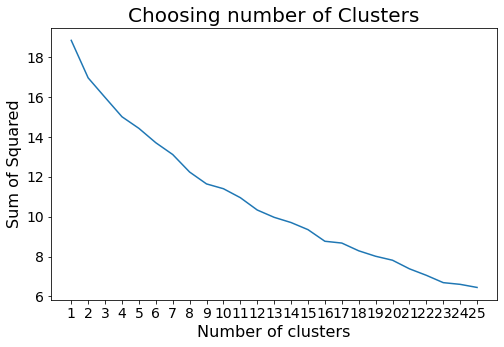

In [16]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(1,26), sse_list)
plt.xticks(np.arange(1,26), size=14)
plt.yticks(size=14)
plt.title('Choosing number of Clusters', size=20)
plt.ylabel('Sum of Squared', size=16)
plt.xlabel('Number of clusters', size=16)
plt.show()

It seems that 6 clusters is a good number of clusters

**Initiate K-Means with 6 clusters and train the model, also create a copy of top 10 dataframe as clustered**

In [18]:
kmeans = KMeans(n_clusters=6, n_init=20).fit(feat)
Toronto_top_10_clustered = Toronto_top_10.copy()

**remove non-retrievable locations from original dataframe and merge with clustered top 10 venues dataframe** (There are 5 locations that cannot be located using Foursquare API, it returns None)

In [19]:
postal_list = []
borough_list = []
hood_list = []
lat_list = []
lng_list =[]
for postal in Toronto_top_10_clustered['Postal Code'].values:
    for i, row in df.iterrows():
        if postal==row['Postal Code']:
            postal_list.append(row['Postal Code'])
            borough_list.append(row['Borough'])
            hood_list.append(row['Neighborhood'])
            lat_list.append(row['Latitude'])
            lng_list.append(row['Longitude'])

df_new = pd.DataFrame([postal_list,borough_list,hood_list,lat_list,lng_list, kmeans.labels_]).T
df_new.columns = ['Postal Code','Borough','Neighborhoods', 'Latitude', 'Longitude', 'Cluster label']
Toronto_top_10_clustered = df_new.join(Toronto_top_10_clustered.set_index('Postal Code'), on='Postal Code')
Toronto_top_10_clustered.head()

,Postal Code,Borough,Neighborhoods,Latitude,Longitude,Cluster label,No.1 Most common Venue,No.2 Most common Venue,No.3 Most common Venue,No.4 Most common Venue,No.5 Most common Venue,No.6 Most common Venue,No.7 Most common Venue,No.8 Most common Venue,No.9 Most common Venue,No.10 Most common Venue
0,M1B,Scarborough,Malvern / Rouge,43.8067,-79.1944,0,Fast Food Restaurant,Deli / Bodega,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek,43.7845,-79.1605,0,Golf Course,Moving Target,Bar,Yoga Studio,Discount Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Distribution Center
2,M1E,Scarborough,Guildwood / Morningside / West Hill,43.7636,-79.1887,0,Rental Car Location,Mexican Restaurant,Breakfast Spot,Medical Center,Intersection,Bank,Electronics Store,Convenience Store,Convention Center,Eastern European Restaurant
3,M1G,Scarborough,Woburn,43.771,-79.2169,0,Coffee Shop,Indian Restaurant,Korean Restaurant,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Yoga Studio
4,M1H,Scarborough,Cedarbrae,43.7731,-79.2395,0,Fried Chicken Joint,Gas Station,Bakery,Hakka Restaurant,Bank,Athletics & Sports,Caribbean Restaurant,Thai Restaurant,Dessert Shop,Dim Sum Restaurant


**Get coordinated of Toronto and create the map with its coordinates**

In [20]:
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode('Toronto, Ontario')
latitude = location.latitude
longitude = location.longitude

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

**Create 6 colors, plot each cluster as a different color using a Circle Marker with popup labels on each neighborhood**

In [21]:
colors = ['red', 'blue', 'green', 'purple', 'orange', 'grey']
for lat, lng, hood, label in zip(Toronto_top_10_clustered['Latitude'], Toronto_top_10_clustered['Longitude'], Toronto_top_10_clustered['Neighborhoods'], Toronto_top_10_clustered['Cluster label']):
    
    Cluster_label = folium.Popup(str(hood) + ' Cluster ' + str(label), parse_html=True)
    
    folium.CircleMarker([lat, lng],
                        radius=5,
                        popup=Cluster_label,
                        color=colors[label],
                        fill=True,
                        fill_color=colors[label],
                        fill_opacity=0.7
                       ).add_to(map_clusters)
map_clusters

**Take a look at the number of neighborhoods in each cluster**

In [22]:
pd.set_option('display.max_rows', None)
Toronto_top_10_clustered['Cluster label'].value_counts(sort=False)

0    88
1     1
2     1
3     4
4     4
5     2
Name: Cluster label, dtype: int64

**Cluster 1**

In [23]:
Toronto_top_10_clustered.loc[Toronto_top_10_clustered['Cluster label'] == 0, Toronto_top_10_clustered.columns[[1] + list(range(5, Toronto_top_10_clustered.shape[1]))]].reset_index(drop=True)[
'No.1 Most common Venue'].value_counts().head(10)

Coffee Shop             18
Park                     8
Café                     8
Grocery Store            5
Pizza Place              5
Clothing Store           4
Gym                      4
Rental Car Location      2
Fast Food Restaurant     2
Indian Restaurant        2
Name: No.1 Most common Venue, dtype: int64

Convenient Area, where we can find most type of venue categories

**Cluster 2**

In [24]:
Toronto_top_10_clustered.loc[Toronto_top_10_clustered['Cluster label'] == 1, Toronto_top_10_clustered.columns[[1] + list(range(5, Toronto_top_10_clustered.shape[1]))]].reset_index(drop=True)[
'No.1 Most common Venue'].value_counts().head(10)

Cafeteria    1
Name: No.1 Most common Venue, dtype: int64

People around here enjoys coffee

**Cluster 3**

In [25]:
Toronto_top_10_clustered.loc[Toronto_top_10_clustered['Cluster label'] == 2, Toronto_top_10_clustered.columns[[1] + list(range(5, Toronto_top_10_clustered.shape[1]))]].reset_index(drop=True)[
'No.1 Most common Venue'].value_counts().head(10)

Filipino Restaurant    1
Name: No.1 Most common Venue, dtype: int64

People around here like Filipino foods

**Cluster 4**

In [26]:
Toronto_top_10_clustered.loc[Toronto_top_10_clustered['Cluster label'] == 3, Toronto_top_10_clustered.columns[[1] + list(range(5, Toronto_top_10_clustered.shape[1]))]].reset_index(drop=True)[
'No.1 Most common Venue'].value_counts().head(10)

Park    4
Name: No.1 Most common Venue, dtype: int64

People came here to visit Parks

**Cluster 5**

In [27]:
Toronto_top_10_clustered.loc[Toronto_top_10_clustered['Cluster label'] == 4, Toronto_top_10_clustered.columns[[1] + list(range(5, Toronto_top_10_clustered.shape[1]))]].reset_index(drop=True)[
'No.1 Most common Venue'].value_counts().head(10)

Park                3
Business Service    1
Name: No.1 Most common Venue, dtype: int64

People around here go for park & business services

**Cluster 6**

In [28]:
Toronto_top_10_clustered.loc[Toronto_top_10_clustered['Cluster label'] == 5, Toronto_top_10_clustered.columns[[1] + list(range(5, Toronto_top_10_clustered.shape[1]))]].reset_index(drop=True)[
'No.1 Most common Venue'].value_counts().head()

Pool    1
Park    1
Name: No.1 Most common Venue, dtype: int64

People around go to pool & park